# Modelo de aprendizaje profundo para la conducción autónoma de un coche robótico
El modelo está construido a partir del modelo ya entrenado MobileNetV2, un modelo de clasificación de imágenes.

*Autor: Andrés Martínez Martínez*

##Imports

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# generales
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# imágenes
from imgaug import augmenters as iaa
from PIL import Image

# aprendizaje automático
import tensorflow as tf
import keras
import cv2

print( f'tf.version: {tf.__version__}')
print( f'keras.version: {keras.__version__}')

tf.version: 2.8.2
keras.version: 2.8.0


## Cargado de imágenes

In [ ]:
data_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/data'
model_output_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/trained-models'

In [ ]:
'''
file_list = os.listdir(data_dir + '/manual-images-v2/images')

# mueve algunas imágenes a la carpeta de validación
for i in range(len(file_list)):
  if np.random.rand() < 0.1:
    os.rename(data_dir + '/manual-images-v2/images/' + file_list[i], data_dir + '/validation/images/' + file_list[i])'''

"# training\nfile_list = os.listdir(data_dir + '/manual-images-v2/images')\n\n# move some training images to validation\nfor i in range(len(file_list)):\n  if np.random.rand() < 0.1:\n    os.rename(data_dir + '/manual-images-v2/images/' + file_list[i], data_dir + '/validation/images/' + file_list[i])"

In [ ]:
# obtiene los ángulos de giro para el entrenamiento
tfile_list = os.listdir(data_dir + '/manual-images-v2/images')
tfile_list = sorted(tfile_list)
tsteering_angles = [int(name[-7:-4]) for name in tfile_list]

# obtiene los ángulos de giro para la validación
vfile_list = os.listdir(data_dir + '/validation/images')
vfile_list = sorted(vfile_list)
vsteering_angles = [int(name[-7:-4]) for name in vfile_list]

print('number of training images: %d' % len(tfile_list))
print('number of validation images: %d' % len(vfile_list))

number of training images: 8695
number of validation images: 786


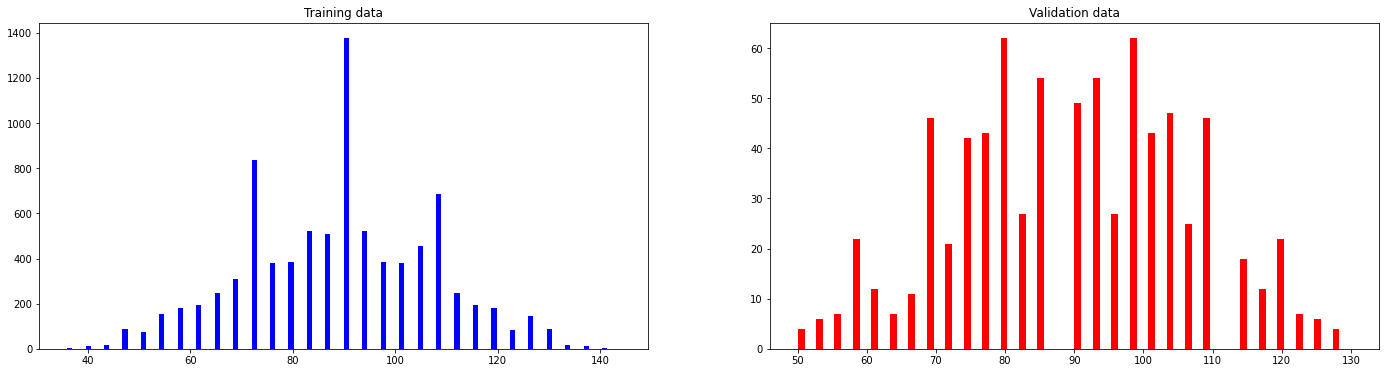

In [ ]:
# comprueba la distribución de los ángulos
fig, axes = plt.subplots(1,2, figsize=(24, 6))
axes[0].hist(tsteering_angles, bins=30, width=1, color='blue')
axes[0].set_title('Ángulos de entrenamiento')
axes[1].hist(vsteering_angles, bins=30, width=1, color='red')
axes[1].set_title('Ángulos de validación')
plt.show()

## Creación de los conjuntos de datos

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/manual-images-v2', 
    labels=tsteering_angles, 
    label_mode='int', 
    color_mode='rgb',
    batch_size=64,
    image_size=(240,320),
    seed=123)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/validation', 
    labels=vsteering_angles, 
    label_mode='int', 
    color_mode='rgb',
    batch_size=64,
    image_size=(224,320),
    seed=123) 

Found 8695 files belonging to 1 classes.
Found 786 files belonging to 1 classes.


## Comprobación de los conjuntos de datos

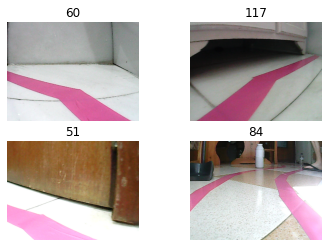

In [ ]:
images = []
while len(images) < 4:
  for images, labels in train_dataset.take(1):
    im_shape = images[1].shape
    for i in range(4):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(labels[i].numpy())
      plt.axis('off')

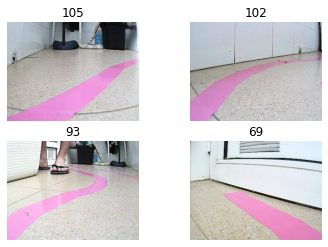

In [ ]:
images = []
while len(images) < 4:
  for images, labels in val_dataset.take(1):
    im_shape = images[1].shape
    for i in range(4):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(labels[i].numpy())
      plt.axis('off')

## Modelo de aprendizaje profundo

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

print('Capas del modelo base: ', len(base_model.layers))

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step
Layers of the base model:  154


In [ ]:
preprocessing_layers = tf.keras.Sequential([
  tf.keras.layers.Cropping2D(cropping=((120,0),(0,0))),
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.Rescaling(1./127.5,offset=-1)])

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Cropping2D(cropping=((120,0),(0,0))),
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.Rescaling(1./127.5,offset=-1),
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3,activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse',
              optimizer='adam')

In [ ]:
model.build((64,240,320,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_1 (Cropping2D)   (64, 120, 320, 3)         0         
                                                                 
 resizing_1 (Resizing)       (64, 224, 224, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (64, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (64, 5, 5, 32)            368672    
                                                                 
 global_average_pooling2d (G  (64, 32)                 0         
 lobalAveragePooling2D)                               

## Entrenamiento

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane-nav-mobilenet.h5'), verbose=1, save_best_only=True)

history = model.fit(train_dataset,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint_callback],
                    validation_data=val_dataset)

Epoch 1/10
136/136 [==============================] - ETA: 0s - loss: 511.9925
Epoch 1: val_loss improved from inf to 271.85437, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/trained-models/lane-nav-mobilenet.h5
136/136 [==============================] - 647s 3s/step - loss: 511.9925 - val_loss: 271.8544
Epoch 2/10
136/136 [==============================] - ETA: 0s - loss: 214.1069
Epoch 2: val_loss improved from 271.85437 to 237.44781, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/trained-models/lane-nav-mobilenet.h5
136/136 [==============================] - 335s 2s/step - loss: 214.1069 - val_loss: 237.4478
Epoch 3/10
136/136 [==============================] - ETA: 0s - loss: 165.8303
Epoch 3: val_loss improved from 237.44781 to 222.08911, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/trained-models/lane-nav-mobilenet.h5
136/136 [==============================] - 343s 3s/step - loss: 165.

In [ ]:
model.save(os.path.join(model_output_dir,'lane_navigation_MobileNet.h5'))

## Curvas de aprendizaje

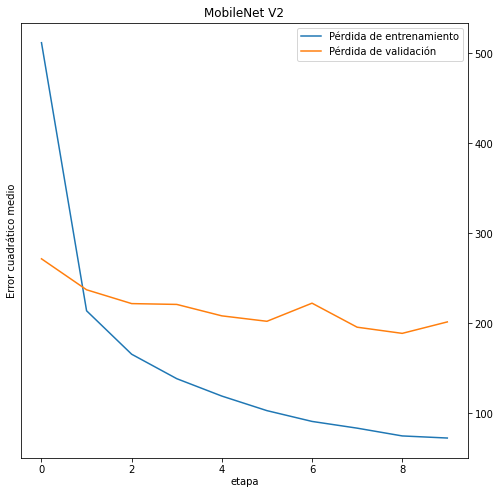

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss[:10], label='Pérdida de entrenamiento')
ax.plot(val_loss[:10], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.ylabel('Error cuadrático medio')
plt.title('MobileNet V2')
plt.xlabel('etapa',labelpad=2)
ax.yaxis.tick_right()
plt.show()

## Ajuste del modelo

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
base_model.trainable = True

fine_tuning_threshold = 100
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam(1e-5))


print(len(model.trainable_variables))

58


## Entrenamiento de ajuste

In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=15,
                         verbose=1,
                         initial_epoch=history.epoch[-1], 
                         callbacks=[checkpoint_callback],
                         validation_data=test_dataset)

Epoch 10/15
49/49 [==============================] - ETA: 0s - loss: 1245.5240
Epoch 10: val_loss did not improve from 1068.45740
49/49 [==============================] - 222s 5s/step - loss: 1245.5240 - val_loss: 1292.7770
Epoch 11/15
49/49 [==============================] - ETA: 0s - loss: 978.2178
Epoch 11: val_loss did not improve from 1068.45740
49/49 [==============================] - 222s 4s/step - loss: 978.2178 - val_loss: 1346.6199
Epoch 12/15
49/49 [==============================] - ETA: 0s - loss: 897.9557
Epoch 12: val_loss did not improve from 1068.45740
49/49 [==============================] - 218s 4s/step - loss: 897.9557 - val_loss: 1354.1938
Epoch 13/15
49/49 [==============================] - ETA: 0s - loss: 828.5735
Epoch 13: val_loss did not improve from 1068.45740
49/49 [==============================] - 219s 4s/step - loss: 828.5735 - val_loss: 1359.4701
Epoch 14/15
49/49 [==============================] - ETA: 0s - loss: 766.6420
Epoch 14: val_loss did not impro

## Curvas de aprendizaje del ajuste

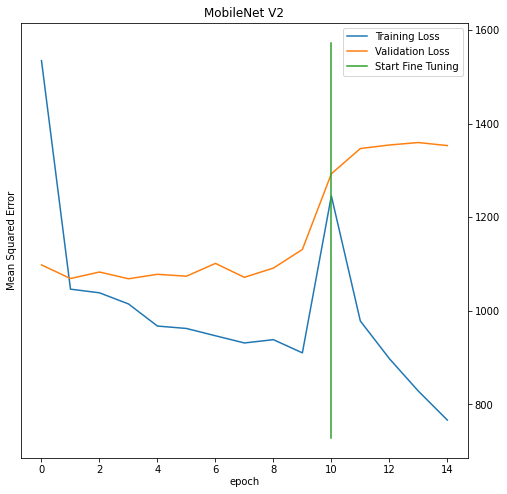

In [ ]:
#loss = history.history['loss']
#val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss[:15], label='Pérdida de entrenamiento')
ax.plot(val_loss[:15], label='Pérdida de validación')
ax.plot([10,10],
          plt.ylim(), label='Inicio del ajuste')
plt.legend(loc='upper right')
plt.ylabel('Error cuadrático medio')
plt.title('MobileNet V2')
plt.xlabel('etapa',labelpad=2)
ax.yaxis.tick_right()
plt.show()